In [241]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import timeit
import json

os.environ["DGLBACKEND"] = "pytorch"

from dgl import from_networkx
from dgl.nn.pytorch import EdgeWeightNorm
import networkx as nx


import torch as th
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import itertools

from src.models import EGRAPHSAGE, EGAT, EGCN
from src.dataset.dataset_info import datasets
from src.graph.graph_measures import calculate_graph_measures

# datasets = {dataset.name: dataset for dataset in datasets_list}

num_epochs = 100
batch_size = 128
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001

e_gcn = True

e_gcn_res = True

e_graph_sage = True

e_graph_sage_res = True

e_gat = True

e_gat_res = True

In [242]:
# name = "cic_ton_iot_5_percent"
# name = "cic_ton_iot"
# name = "cic_ids_2017_5_percent"
# name = "cic_ids_2017"
# name = "cic_bot_iot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"
# name = "edge_iiot"
# name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
# name = "nf_uq_nids"
# name = "x_iiot"

with_centralities = False

if with_centralities:
    suffix = "_with_centralities"
else:
    suffix = ""

dataset = datasets[name]

In [243]:
results_final = {}

results_final["name"] = name
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "with_centralities": with_centralities,
    # "early_stopping": early_stopping,
    # "pca": pca,
    # "digraph_centralities": digraph_centralities,
    # "multi_graph_centralities": multi_graph_centralities,
    # "learning_rate": learning_rate,
    # "LAMBD_1": LAMBD_1,
    # "LAMBD_2": LAMBD_2,
    # "cfg": OmegaConf.to_container(cfg)
}

results_final["accuracy"] = {}
results_final["time_elapsed"] = {}

if e_gcn:
    results_final["e_gcn"] = {}

if e_gcn_res:
    results_final["e_gcn_res"] = {}

if e_graph_sage:
    results_final["e_graph_sage"] = {}

if e_graph_sage_res:
    results_final["e_graph_sage_res"] = {}

if e_gat:
    results_final["e_gat"] = {}

if e_gat_res:
    results_final["e_gat_res"] = {}


results_final

{'name': 'ccd_inid_modified',
 'configuration': {'num_epochs': 100,
  'batch_size': 128,
  'with_centralities': False},
 'accuracy': {},
 'time_elapsed': {},
 'e_gcn': {},
 'e_gcn_res': {},
 'e_graph_sage': {},
 'e_graph_sage_res': {},
 'e_gat': {},
 'e_gat_res': {}}

In [244]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

'20241121-140053'

In [245]:
results_folder_path = "results"
if not os.path.isdir(results_folder_path):
    os.mkdir(results_folder_path)

results_folder_path1 = os.path.join(results_folder_path, name)
if not os.path.isdir(results_folder_path1):
    os.mkdir(results_folder_path1)

folder_path = os.path.join(results_folder_path1, dtime)
if not os.path.isdir(folder_path):
    os.mkdir(folder_path)

confusion_matrices_path = os.path.join(folder_path, "confusion_matrices")
if not os.path.isdir(confusion_matrices_path):
    os.mkdir(confusion_matrices_path)

In [246]:
with open(f"datasets/{name}/training_graph{suffix}.pkl", "rb") as f:
    G = pickle.load(f)

In [247]:
G = from_networkx(G,  edge_attrs=['h', dataset.label_col])

In [248]:
num_features = G.edata['h'].shape[1]
num_features

24

In [249]:
G.ndata['h'] = th.ones(G.num_nodes(), num_features)

G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, num_features))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, num_features))

G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [250]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(
                                                      G.edata[dataset.label_col].cpu().numpy()),
                                                  y=G.edata[dataset.label_col].cpu().numpy())

In [251]:
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [252]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [253]:
def train_gnn(model_class, Graph, residual, num_neighbors=None, norm=None):
    node_features = Graph.ndata['h']
    edge_features = Graph.edata['h']

    edge_label = Graph.edata[dataset.label_col]
    train_mask = Graph.edata['train_mask']

    # model = EGRAPHSAGE(num_features, num_features, 128, F.relu,
    #                    dropout=0.2, num_neighbors=4, residual=residual)

    if norm:
        edge_weight = th.ones(Graph.num_edges(), dtype=th.float32)
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(Graph, edge_weight)
        Graph.edata['norm_weight'] = norm_edge_weight

    if num_neighbors:
        model = model_class(num_features, num_features, 128, F.relu,
                            dropout=0.2, num_neighbors=num_neighbors, residual=residual)
    else:
        model = model_class(num_features, num_features, 128, F.relu,
                            dropout=0.2, residual=residual)

    opt = th.optim.Adam(model.parameters())

    for epoch in range(1, num_epochs):
        #     pred = model(G, node_features,edge_features).cuda()
        pred = model(Graph, node_features, edge_features)
        loss = criterion(pred[train_mask], edge_label[train_mask])
        opt.zero_grad()
        loss.backward()
        opt.step()
        print('Epoch:', epoch, ' Training acc:', compute_accuracy(
            pred[train_mask], edge_label[train_mask]))

    return model

### Training EGCN

In [254]:
if e_gcn:
    model_gcn = train_gnn(EGCN, G, False, None, True)

Epoch: 1  Training acc: 0.5204610824584961
Epoch: 2  Training acc: 0.47960567474365234
Epoch: 3  Training acc: 0.4795389175415039
Epoch: 4  Training acc: 0.4795389175415039
Epoch: 5  Training acc: 0.47965019941329956
Epoch: 6  Training acc: 0.5257571339607239
Epoch: 7  Training acc: 0.5257126092910767
Epoch: 8  Training acc: 0.5257126092910767
Epoch: 9  Training acc: 0.5257126092910767
Epoch: 10  Training acc: 0.525935173034668
Epoch: 11  Training acc: 0.4786710739135742
Epoch: 12  Training acc: 0.4797614514827728
Epoch: 13  Training acc: 0.4797614514827728
Epoch: 14  Training acc: 0.4797614514827728
Epoch: 15  Training acc: 0.6319900155067444
Epoch: 16  Training acc: 0.5362602472305298
Epoch: 17  Training acc: 0.5260463953018188
Epoch: 18  Training acc: 0.5259796380996704
Epoch: 19  Training acc: 0.5259574055671692
Epoch: 20  Training acc: 0.5260463953018188
Epoch: 21  Training acc: 0.5360822677612305
Epoch: 22  Training acc: 0.5368833541870117
Epoch: 23  Training acc: 0.4508556127548

### Training EGCN residual

In [255]:
if e_gcn_res:
    model_gcn_res = train_gnn(EGCN, G, True, None, True)

Epoch: 1  Training acc: 0.5564654469490051
Epoch: 2  Training acc: 0.705289363861084
Epoch: 3  Training acc: 0.7080487012863159
Epoch: 4  Training acc: 0.7287211418151855
Epoch: 5  Training acc: 0.7540221214294434
Epoch: 6  Training acc: 0.765860378742218
Epoch: 7  Training acc: 0.7738267183303833
Epoch: 8  Training acc: 0.7817931175231934
Epoch: 9  Training acc: 0.7885133028030396
Epoch: 10  Training acc: 0.7925854921340942
Epoch: 11  Training acc: 0.796079158782959
Epoch: 12  Training acc: 0.8058479428291321
Epoch: 13  Training acc: 0.8076280951499939
Epoch: 14  Training acc: 0.8092302680015564
Epoch: 15  Training acc: 0.8113442659378052
Epoch: 16  Training acc: 0.8135250210762024
Epoch: 17  Training acc: 0.8154609799385071
Epoch: 18  Training acc: 0.816640317440033
Epoch: 19  Training acc: 0.8178642392158508
Epoch: 20  Training acc: 0.8194886445999146
Epoch: 21  Training acc: 0.8204232454299927
Epoch: 22  Training acc: 0.8213133215904236
Epoch: 23  Training acc: 0.8214691281318665
E

### Training EGraphSage 

In [256]:
if e_graph_sage:
    model_sage = train_gnn(EGRAPHSAGE, G, False, [25, 10])

Epoch: 1  Training acc: 0.5209951400756836
Epoch: 2  Training acc: 0.5207058191299438
Epoch: 3  Training acc: 0.5274038314819336
Epoch: 4  Training acc: 0.5617837309837341
Epoch: 5  Training acc: 0.9244309067726135
Epoch: 6  Training acc: 0.9304835200309753
Epoch: 7  Training acc: 0.9321079850196838
Epoch: 8  Training acc: 0.9408754110336304
Epoch: 9  Training acc: 0.9306615591049194
Epoch: 10  Training acc: 0.9124146103858948
Epoch: 11  Training acc: 0.9098333120346069
Epoch: 12  Training acc: 0.94737309217453
Epoch: 13  Training acc: 0.9146621227264404
Epoch: 14  Training acc: 0.9224726557731628
Epoch: 15  Training acc: 0.9147956371307373
Epoch: 16  Training acc: 0.9449253678321838
Epoch: 17  Training acc: 0.9147733449935913
Epoch: 18  Training acc: 0.9449253678321838
Epoch: 19  Training acc: 0.9147956371307373
Epoch: 20  Training acc: 0.9146843552589417
Epoch: 21  Training acc: 0.9474843740463257
Epoch: 22  Training acc: 0.9147956371307373
Epoch: 23  Training acc: 0.947395384311676


### Training EGraphSage residual

In [257]:
if e_graph_sage_res:
    model_sage_res = train_gnn(EGRAPHSAGE, G, True, [25, 10])

Epoch: 1  Training acc: 0.42413049936294556
Epoch: 2  Training acc: 0.529139518737793
Epoch: 3  Training acc: 0.5196822285652161
Epoch: 4  Training acc: 0.6379091739654541
Epoch: 5  Training acc: 0.6472106575965881
Epoch: 6  Training acc: 0.679988443851471
Epoch: 7  Training acc: 0.7904047966003418
Epoch: 8  Training acc: 0.9018447399139404
Epoch: 9  Training acc: 0.9129041433334351
Epoch: 10  Training acc: 0.9386501908302307
Epoch: 11  Training acc: 0.8995304703712463
Epoch: 12  Training acc: 0.9381161332130432
Epoch: 13  Training acc: 0.9436124563217163
Epoch: 14  Training acc: 0.9136829972267151
Epoch: 15  Training acc: 0.897972822189331
Epoch: 16  Training acc: 0.9082534313201904
Epoch: 17  Training acc: 0.9143950939178467
Epoch: 18  Training acc: 0.9542268514633179
Epoch: 19  Training acc: 0.9540488123893738
Epoch: 20  Training acc: 0.9402968287467957
Epoch: 21  Training acc: 0.914595365524292
Epoch: 22  Training acc: 0.9286810755729675
Epoch: 23  Training acc: 0.9542936086654663


### Training EGAT

In [258]:
if e_gat:
    model_gat = train_gnn(EGAT, G, False, None)

Epoch: 1  Training acc: 0.47993946075439453
Epoch: 2  Training acc: 0.7620329856872559
Epoch: 3  Training acc: 0.9473063349723816
Epoch: 4  Training acc: 0.9474176168441772
Epoch: 5  Training acc: 0.9450365900993347
Epoch: 6  Training acc: 0.9450365900993347
Epoch: 7  Training acc: 0.9450143575668335
Epoch: 8  Training acc: 0.9450588822364807
Epoch: 9  Training acc: 0.9450588822364807
Epoch: 10  Training acc: 0.9449476003646851
Epoch: 11  Training acc: 0.9449476003646851
Epoch: 12  Training acc: 0.9449476003646851
Epoch: 13  Training acc: 0.9474176168441772
Epoch: 14  Training acc: 0.9147065877914429
Epoch: 15  Training acc: 0.9147288799285889
Epoch: 16  Training acc: 0.9147288799285889
Epoch: 17  Training acc: 0.9474398493766785
Epoch: 18  Training acc: 0.9474398493766785
Epoch: 19  Training acc: 0.9474176168441772
Epoch: 20  Training acc: 0.9474176168441772
Epoch: 21  Training acc: 0.9474176168441772
Epoch: 22  Training acc: 0.94737309217453
Epoch: 23  Training acc: 0.947306334972381

### Training EGAT residual

In [259]:
if e_gat_res:
    model_gat_res = train_gnn(EGAT, G, True, None)

Epoch: 1  Training acc: 0.5991677641868591
Epoch: 2  Training acc: 0.7573822140693665
Epoch: 3  Training acc: 0.9381161332130432
Epoch: 4  Training acc: 0.9462605118751526
Epoch: 5  Training acc: 0.950599730014801
Epoch: 6  Training acc: 0.9510002732276917
Epoch: 7  Training acc: 0.9514675736427307
Epoch: 8  Training acc: 0.9523354172706604
Epoch: 9  Training acc: 0.9553171992301941
Epoch: 10  Training acc: 0.9587885737419128
Epoch: 11  Training acc: 0.9607690572738647
Epoch: 12  Training acc: 0.9678007960319519
Epoch: 13  Training acc: 0.9675115346908569
Epoch: 14  Training acc: 0.9686908721923828
Epoch: 15  Training acc: 0.9700705409049988
Epoch: 16  Training acc: 0.9694919586181641
Epoch: 17  Training acc: 0.9703598022460938
Epoch: 18  Training acc: 0.9672222137451172
Epoch: 19  Training acc: 0.9575647115707397
Epoch: 20  Training acc: 0.9536037445068359
Epoch: 21  Training acc: 0.9526692032814026
Epoch: 22  Training acc: 0.9524689316749573
Epoch: 23  Training acc: 0.952402174472808

# Testing

In [260]:
with open(f"datasets/{name}/testing_graph{suffix}.pkl", "rb") as f:
    G_test = pickle.load(f)

In [261]:
G_test = from_networkx(G_test,  edge_attrs=['h', dataset.label_col])

In [262]:
actual_label = G_test.edata.pop(dataset.label_col)
G_test.ndata['feature'] = th.ones(G_test.num_nodes(),  num_features)

In [263]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [264]:
def test_gnn(model, graph, norm=False):
    start_time = timeit.default_timer()

    if norm:
        edge_weight = th.ones(graph.num_edges(), dtype=th.float32)
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(graph, edge_weight)
        graph.edata['norm_weight'] = norm_edge_weight

    node_features_test = graph.ndata['feature']
    edge_features_test = graph.edata['h']
    # test_pred = model(G_test, node_features_test, edge_features_test).cuda()
    test_pred = model(graph, node_features_test, edge_features_test)
    elapsed = timeit.default_timer() - start_time
    print(str(elapsed) + ' seconds')

    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    actual = ["Normal" if i == 0 else "Attack" for i in actual_label]
    test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    return (actual, test_pred, elapsed)

In [265]:

def calculate_FPR_FNR(cm):

    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    return FPR, FNR

In [266]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          file_path=None):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    if file_path:
        plt.savefig(file_path)
    plt.show()

### Testing EGCN

In [267]:
if e_gcn:
    actual, test_pred, elapsed = test_gnn(model_gcn, G_test, norm=True)

0.07785370014607906 seconds


In [268]:
if e_gcn:
    labels = ["Normal", "Attack"]
    cm = confusion_matrix(actual, test_pred, labels=labels)

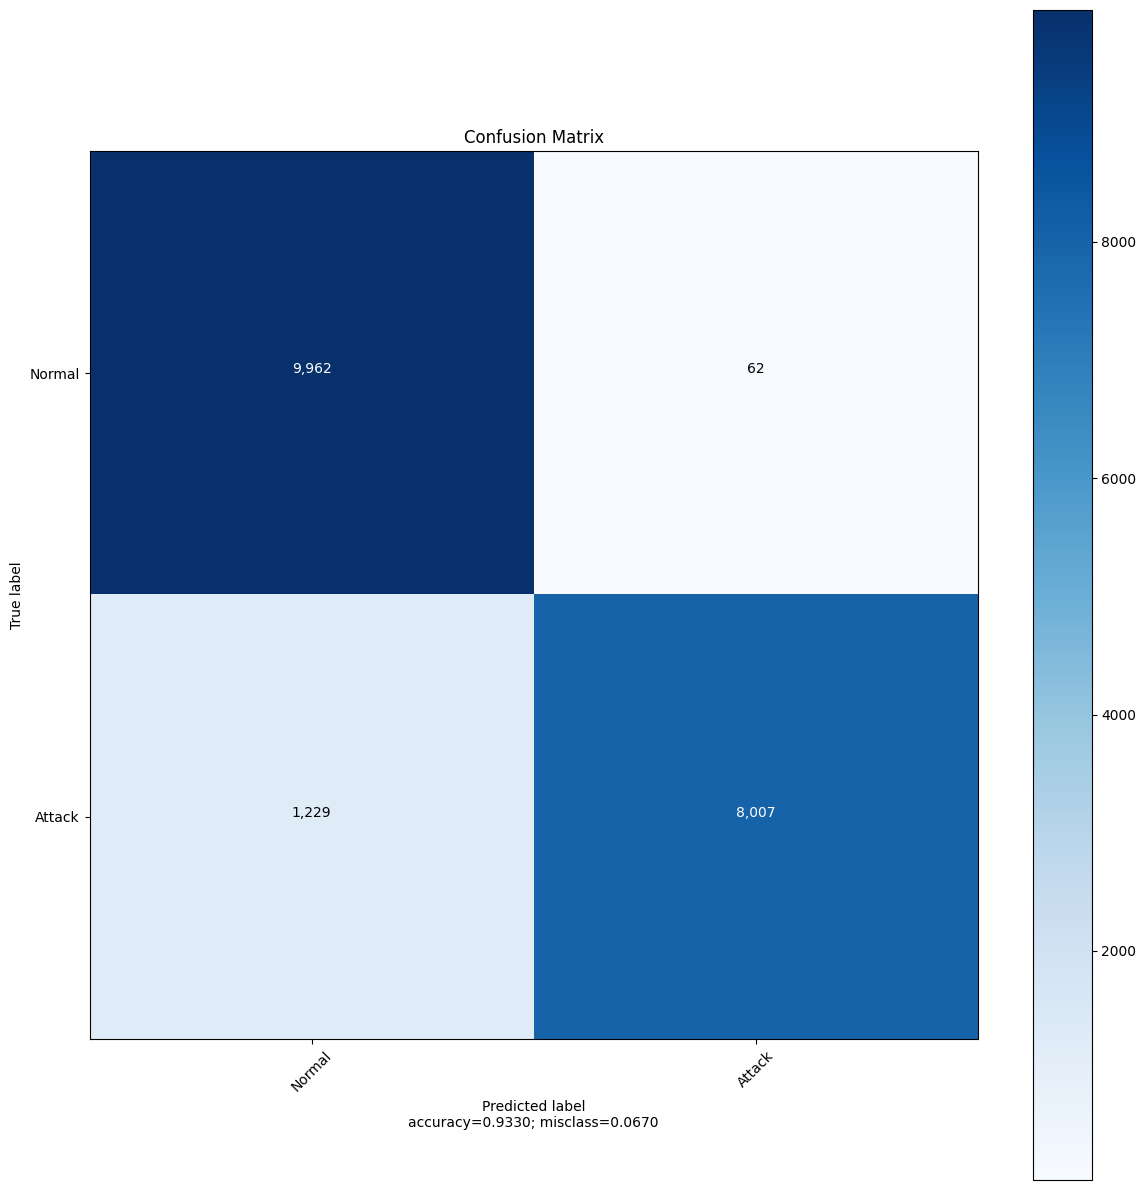

In [269]:
if e_gcn:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_gcn.png')

In [270]:
if e_gcn:
    FPR, FNR = calculate_FPR_FNR(cm)

In [271]:
if e_gcn:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_gcn"]["elapsed"] = elapsed
    results_final["e_gcn"]["classification_report"] = cr
    results_final["e_gcn"]["FPR"] = FPR
    results_final["e_gcn"]["FNR"] = FNR
    results_final["accuracy"]["e_gcn"] = cr["accuracy"]
    results_final["time_elapsed"]["e_gcn"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9923    0.8669    0.9254      9236
      Normal     0.8902    0.9938    0.9391     10024

    accuracy                         0.9330     19260
   macro avg     0.9412    0.9304    0.9323     19260
weighted avg     0.9392    0.9330    0.9326     19260



### Testing EGCN residual

In [272]:
if e_gcn_res:
    actual, test_pred, elapsed = test_gnn(model_gcn_res, G_test, norm=True)

0.05814160034060478 seconds


In [273]:
if e_gcn_res:
    labels = ["Normal", "Attack"]
    cm = confusion_matrix(actual, test_pred, labels=labels)

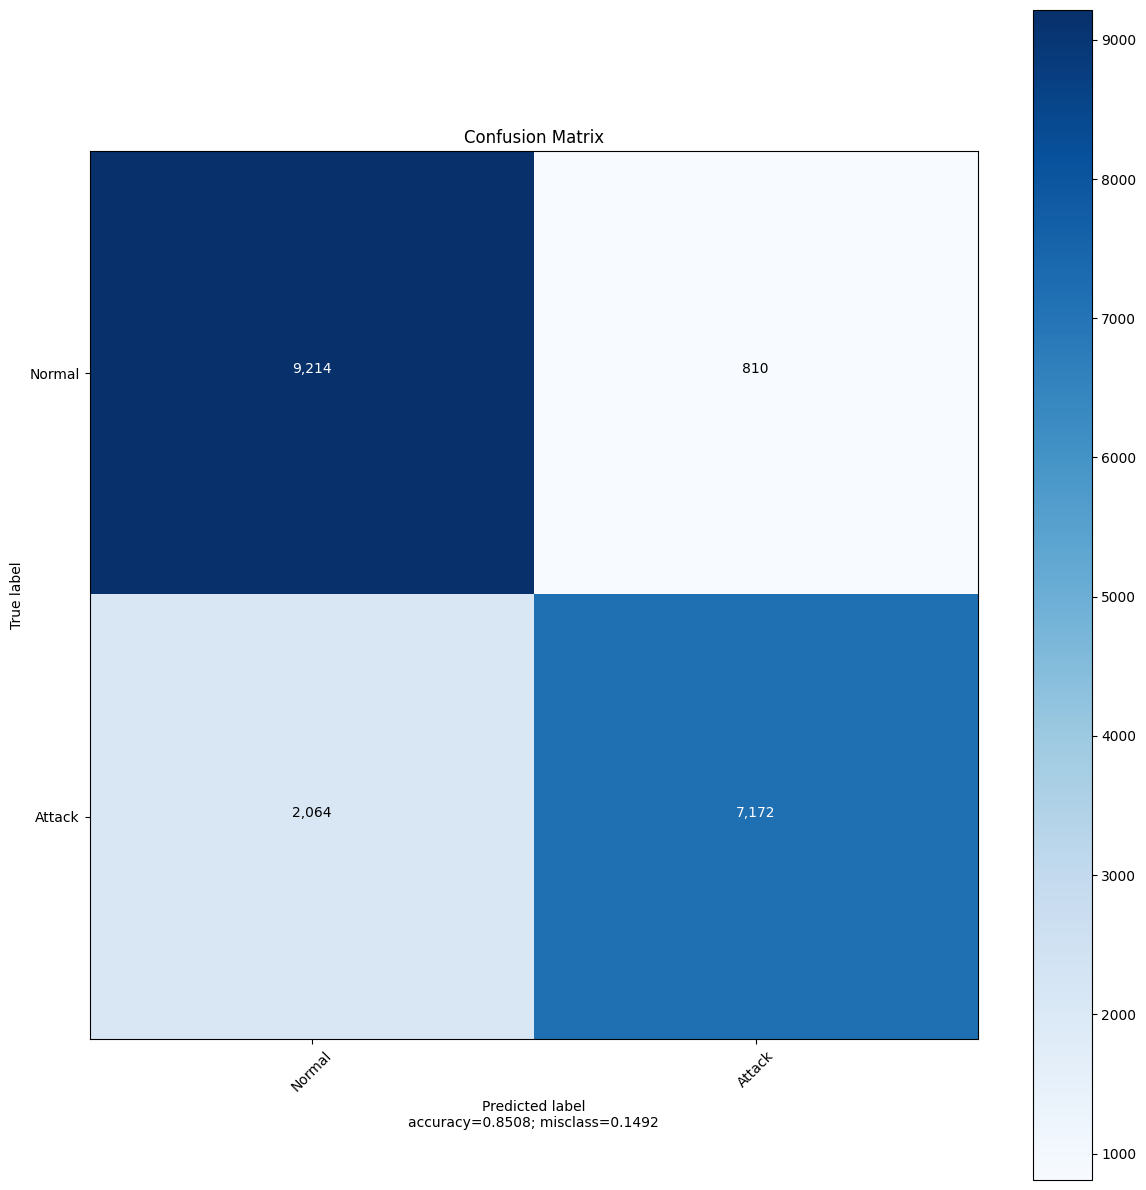

In [274]:
if e_gcn_res:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_gcn_res.png')

In [275]:
if e_gcn_res:
    FPR, FNR = calculate_FPR_FNR(cm)

In [276]:
if e_gcn_res:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_gcn_res"]["elapsed"] = elapsed
    results_final["e_gcn_res"]["classification_report"] = cr
    results_final["e_gcn_res"]["FPR"] = FPR
    results_final["e_gcn_res"]["FNR"] = FNR
    results_final["accuracy"]["e_gcn_res"] = cr["accuracy"]
    results_final["time_elapsed"]["e_gcn_res"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.8985    0.7765    0.8331      9236
      Normal     0.8170    0.9192    0.8651     10024

    accuracy                         0.8508     19260
   macro avg     0.8578    0.8479    0.8491     19260
weighted avg     0.8561    0.8508    0.8497     19260



### Testing EGraphSage

In [277]:
if e_graph_sage:
    actual, test_pred, elapsed = test_gnn(model_sage, G_test)

0.04717889986932278 seconds


In [278]:
if e_graph_sage:
    labels = ["Normal", "Attack"]
    cm = confusion_matrix(actual, test_pred, labels=labels)

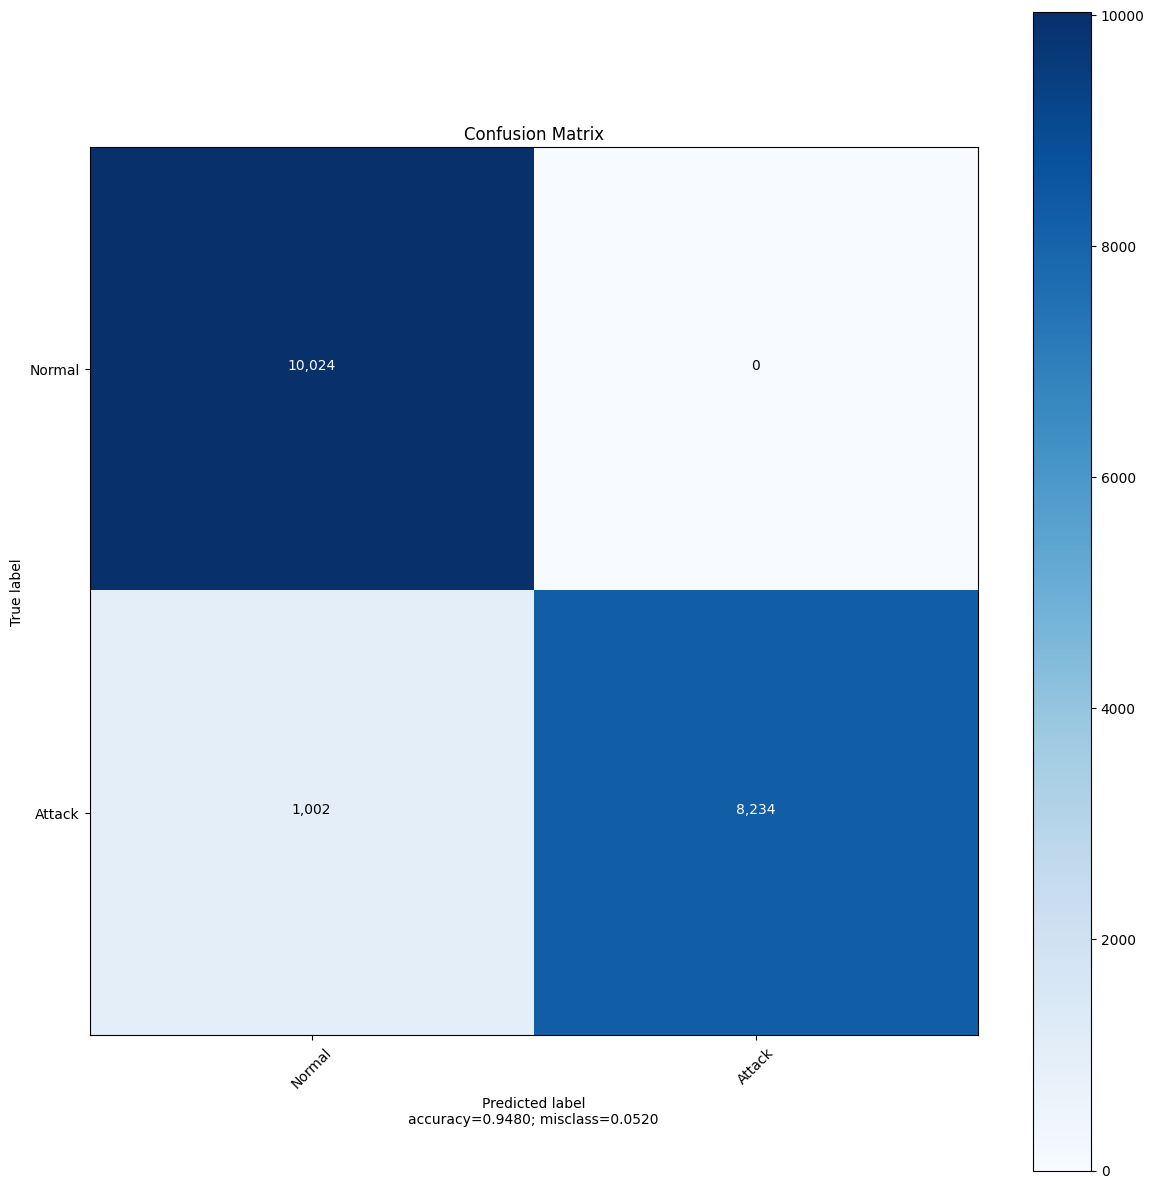

In [279]:
if e_graph_sage:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_graph_sage.png')

In [280]:
if e_graph_sage:
    FPR, FNR = calculate_FPR_FNR(cm)

In [281]:
if e_graph_sage:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_graph_sage"]["elapsed"] = elapsed
    results_final["e_graph_sage"]["classification_report"] = cr
    results_final["e_graph_sage"]["FPR"] = FPR
    results_final["e_graph_sage"]["FNR"] = FNR
    results_final["accuracy"]["e_graph_sage"] = cr["accuracy"]
    results_final["time_elapsed"]["e_graph_sage"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     1.0000    0.8915    0.9426      9236
      Normal     0.9091    1.0000    0.9524     10024

    accuracy                         0.9480     19260
   macro avg     0.9546    0.9458    0.9475     19260
weighted avg     0.9527    0.9480    0.9477     19260



### Testing EGraphSage residual

In [282]:
if e_graph_sage_res:
    actual, test_pred, elapsed = test_gnn(model_sage_res, G_test)

0.02287680096924305 seconds


In [283]:
if e_graph_sage_res:
    labels = ["Normal", "Attack"]
    cm = confusion_matrix(actual, test_pred, labels=labels)

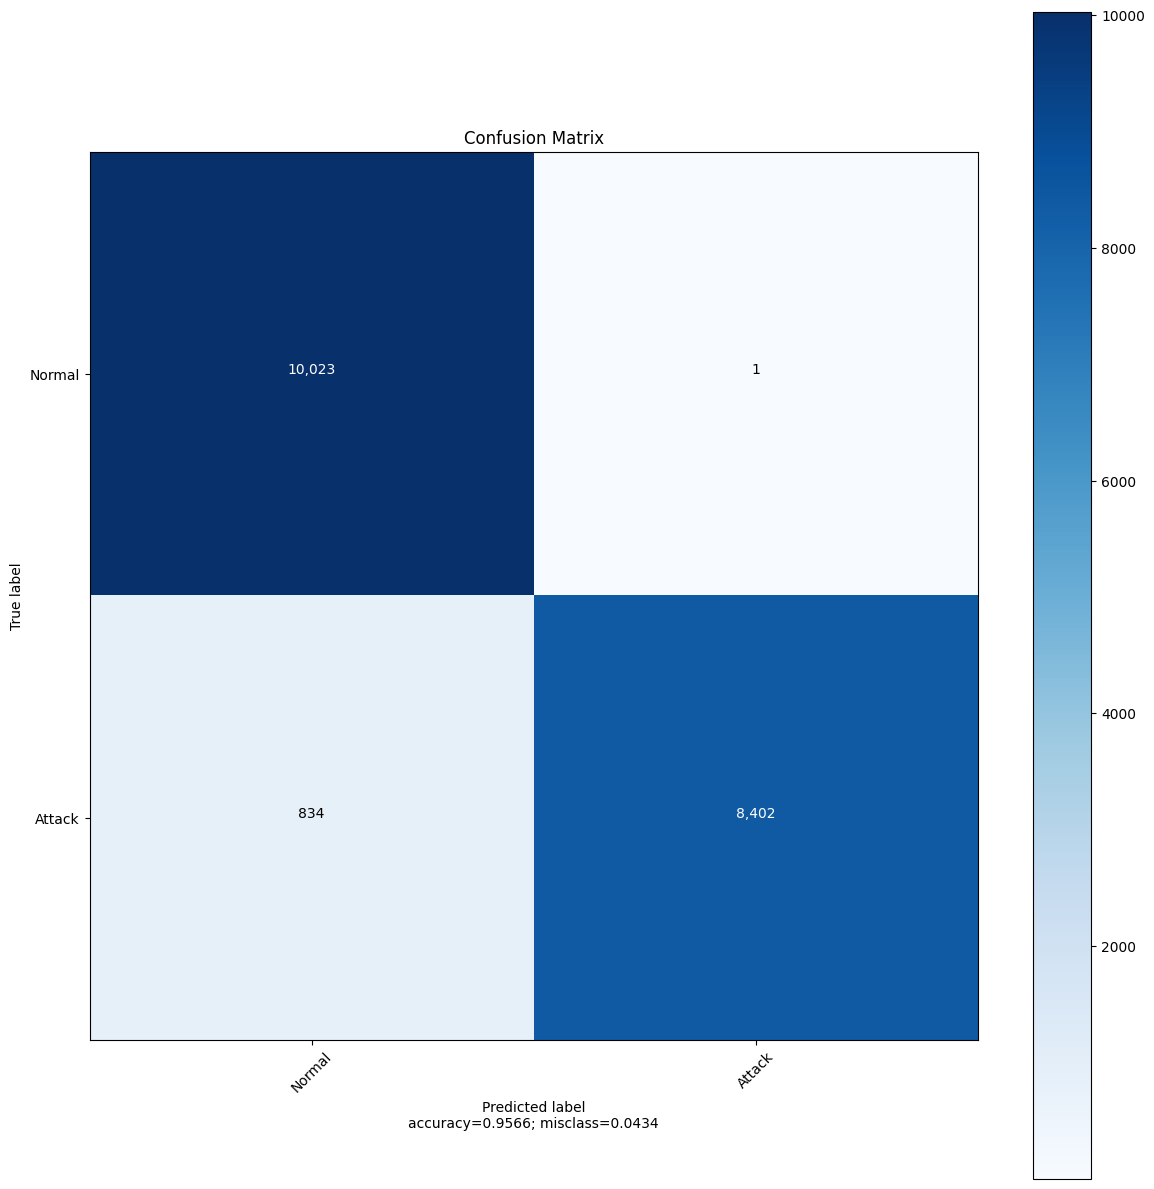

In [284]:
if e_graph_sage_res:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_graph_sage_res.png')

In [285]:
if e_graph_sage_res:
    FPR, FNR = calculate_FPR_FNR(cm)

In [286]:
if e_graph_sage_res:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_graph_sage_res"]["elapsed"] = elapsed
    results_final["e_graph_sage_res"]["classification_report"] = cr
    results_final["e_graph_sage_res"]["FPR"] = FPR
    results_final["e_graph_sage_res"]["FNR"] = FNR
    results_final["accuracy"]["e_graph_sage_res"] = cr["accuracy"]
    results_final["time_elapsed"]["e_graph_sage_res"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9999    0.9097    0.9527      9236
      Normal     0.9232    0.9999    0.9600     10024

    accuracy                         0.9566     19260
   macro avg     0.9615    0.9548    0.9563     19260
weighted avg     0.9600    0.9566    0.9565     19260



### Testing EGAT

In [287]:
if e_gat:
    actual, test_pred, elapsed = test_gnn(model_gat, G_test)

1.0587674994021654 seconds


In [288]:
if e_gat:
    labels = ["Normal", "Attack"]
    cm = confusion_matrix(actual, test_pred, labels=labels)

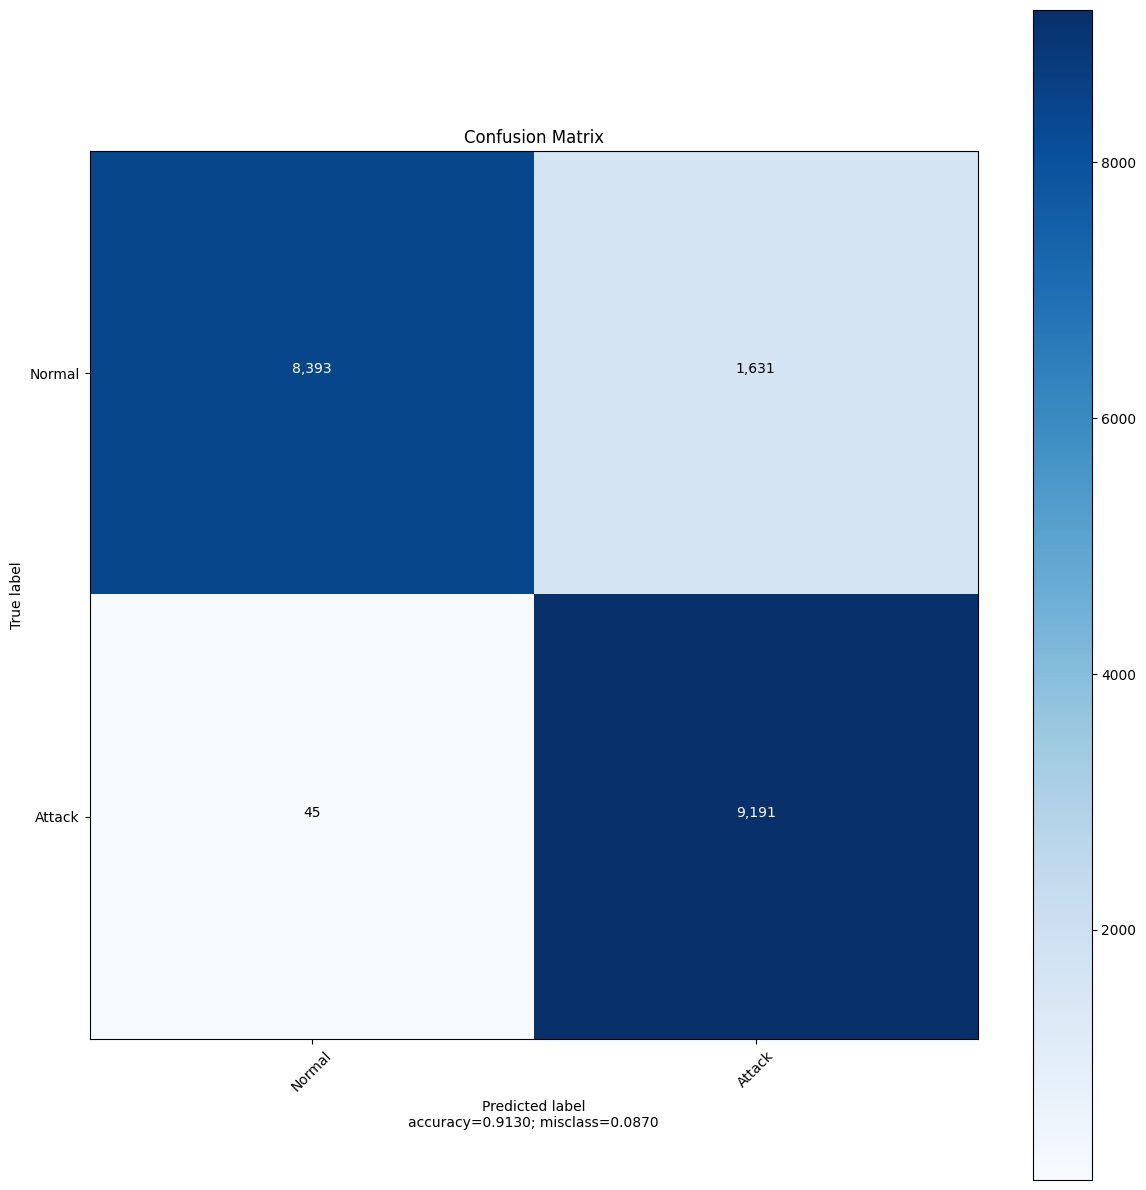

In [289]:
if e_gat:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_gat.png')

In [290]:
if e_gat:
    FPR, FNR = calculate_FPR_FNR(cm)

In [291]:
if e_gat:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_gat"]["elapsed"] = elapsed
    results_final["e_gat"]["classification_report"] = cr
    results_final["e_gat"]["FPR"] = FPR
    results_final["e_gat"]["FNR"] = FNR
    results_final["accuracy"]["e_gat"] = cr["accuracy"]
    results_final["time_elapsed"]["e_gat"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.8493    0.9951    0.9164      9236
      Normal     0.9947    0.8373    0.9092     10024

    accuracy                         0.9130     19260
   macro avg     0.9220    0.9162    0.9128     19260
weighted avg     0.9250    0.9130    0.9127     19260



### Testing EGAT residual

In [292]:
if e_gat_res:
    actual, test_pred, elapsed = test_gnn(model_gat_res, G_test)

1.0394167993217707 seconds


In [293]:
if e_gat_res:
    labels = ["Normal", "Attack"]
    cm = confusion_matrix(actual, test_pred, labels=labels)

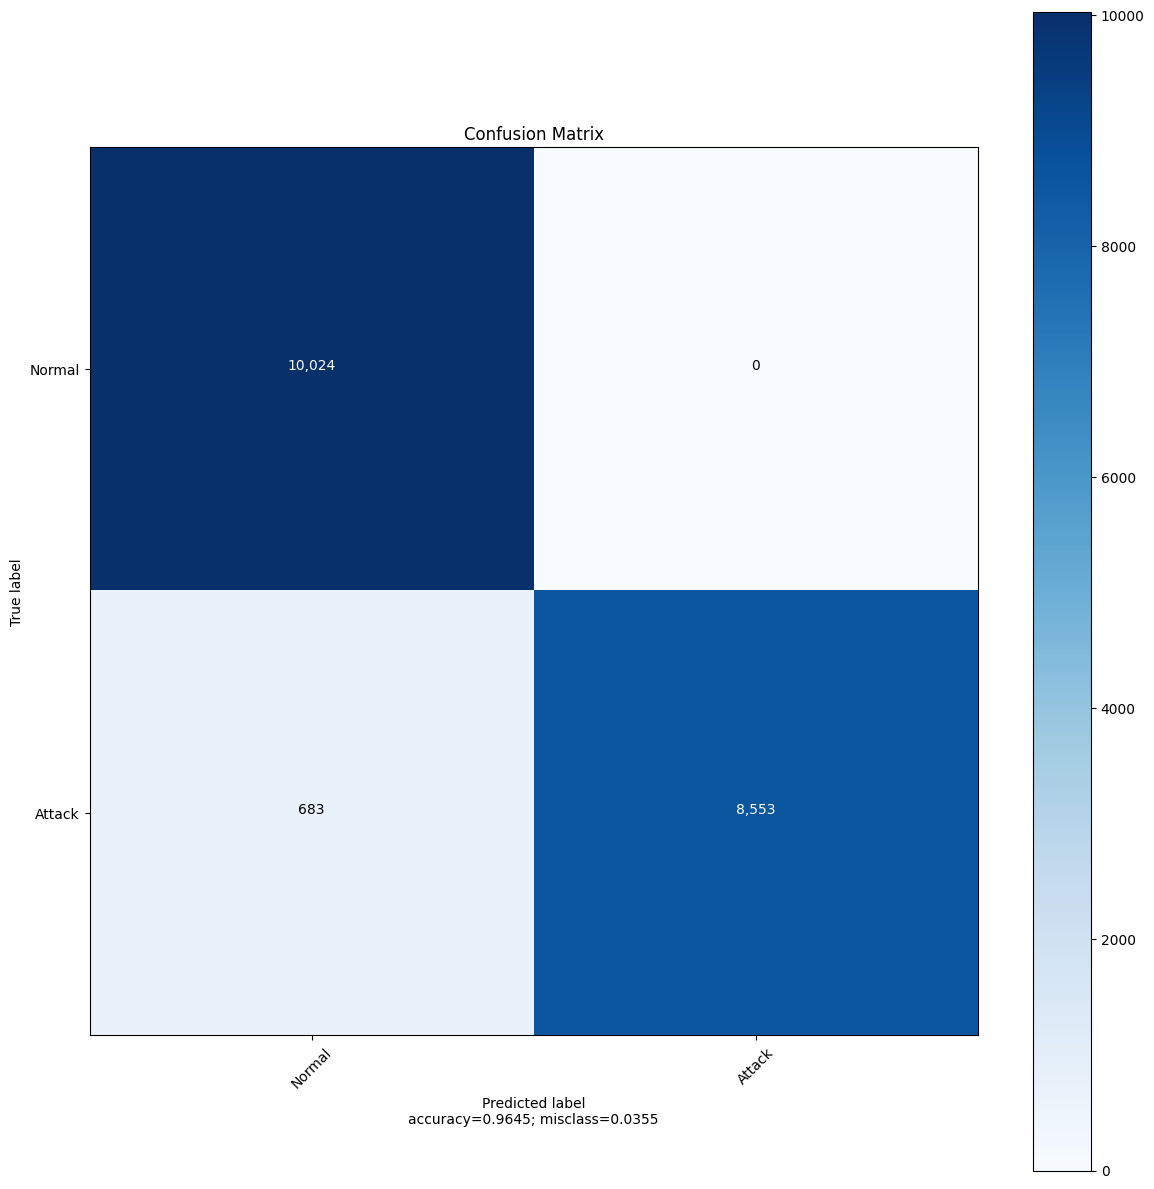

In [294]:
if e_gat_res:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_gat_res.png')

In [295]:
if e_gat_res:
    FPR, FNR = calculate_FPR_FNR(cm)

In [296]:
if e_gat_res:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_gat_res"]["elapsed"] = elapsed
    results_final["e_gat_res"]["classification_report"] = cr
    results_final["e_gat_res"]["FPR"] = FPR
    results_final["e_gat_res"]["FNR"] = FNR
    results_final["accuracy"]["e_gat_res"] = cr["accuracy"]
    results_final["time_elapsed"]["e_gat_res"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     1.0000    0.9261    0.9616      9236
      Normal     0.9362    1.0000    0.9671     10024

    accuracy                         0.9645     19260
   macro avg     0.9681    0.9630    0.9643     19260
weighted avg     0.9668    0.9645    0.9644     19260



### Saving results

In [297]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)


filename = (folder_path + '/results.json'.format(dtime))
outfile = open(filename, 'w')
outfile.writelines(json.dumps(results_final, cls=NumpyEncoder))
outfile.close()